In [1]:
# 1.créer un nouvel env conda à partir du terminal
# conda create --name asr_rag python=3.10

# 2. activer cet environnement
# conda activate asr_rag

# 3. installer les dépendences
# pip install -r requirements.txt

# 4. installer ollama: https://www.ollama.com/download


# 5. installer le modème d'OllamaEmbeddings
# ollama pull embeddinggemma

# 6. créer une clé api sur openrouter pour utiliser des llm gratuitement

# 7. mettre votre clé dans le fichier .env (racine du repertoire courant)

In [2]:
from openai import OpenAI, AsyncOpenAI
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings
from langchain_ollama import OllamaEmbeddings
from langchain.schema.document import Document
from langchain_unstructured import UnstructuredLoader
from pathrag_retriever import create_graphdb, load_existing_graphdb, load_knowledgeGraph_vis
import time
import os
from dotenv import load_dotenv

load_dotenv("./.env")

OPENROUTER_API_KEY=os.getenv("OPENROUTER_API_KEY")

print(OPENROUTER_API_KEY)

/home/chougar/miniconda3/envs/pathrag/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


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


#### Création ou chargement d'un graphe existant:
> Lorsque vous executer la cellule ci dessous, vous avez 2 options proposées:
> 1. Créer un nouveau graphe
> 2. Charger un graphe existant
> 
> Un prompt de sélection s'affichera en haut du notebook<br>
> Saisir l'action désirée dans le , suivre instructions

> Si vous voulez charger un graphe déjà crée et que vous ne savez plus son nom, retrouver le dans le fichier `graphrag_hashes.json` (dans la racine du dossier), attribut `Nom du doc`

> Si vous voulez modifier le LLM utilisé pour la création du graphe ou sa lecture, allez dans `pathrag_retriever.py`, sous la ligne 36( Choix du LLM OpenRouter), et prenez un modèle valide sur openrouter (attention à prendre un modèle qui supporte les `structured_outputs`, sur le site openrouter, à filtrer sur le paneau à gauche dans la liste des `Supported parameters`)

#### 1. Créer un graphe, ou charger en un déjà crée
Ci dessous un print des noms de docs disponibles

In [3]:
import pandas as pd

graph_names=pd.read_json("graphrag_hashes.json")

graph_names=graph_names.loc["Nom du doc", :].values.tolist()
for n in graph_names:
    print(n)

IA conscience
L-IA-notre-deuxieme-conscience


In [4]:
# 1.
import nest_asyncio

nest_asyncio.apply()

#==== params de base====

# Obligatoire: nom des sources
filename="audio-text.txt"
doc_name_graph="L-IA-notre-deuxieme-conscience"

# Optionnels:
# 1. modèle pour création du graph
# param 'OPENROUTER_MODEL_graph_creation', par défaut "deepseek/deepseek-chat-v3-0324"
# passer dans la fonction 'create_graphdb' un autre modèle si vous le souhaitez

# 2. modèle pour lecture du graph (questions/réponses)
# param 'OPENROUTER_MODEL_graph_read', par défaut "deepseek/deepseek-chat-v3-0324"
# passer dans la fonction 'load_existing_graphdb' un autre modèle si vous le souhaitez

#=======================

loader = UnstructuredLoader(filename)

txt_docs = loader.load()
text=""
for doc in txt_docs:
    text+=doc.page_content


graphrag_action=input("Saisir 'C' pour créer un nouveau graphe, 'L' pour charger un graphe existant")

# créer un nouveau graphe
messages=None

if graphrag_action=='C':
    print(f"Le nom de votre graphe est {doc_name_graph}")
    messages= create_graphdb(
        text=text, 
        doc_name=doc_name_graph, # il faut donner un nom unique permettant d'identifier et charger le graph les prochaines fois
    )
# charger un graphe existant
elif graphrag_action=='L':    
    print(f"Le nom de votre graphe est {doc_name_graph}")

    messages=load_existing_graphdb(
        doc_name_graph, 
        # OPENROUTER_MODEL_graph_read="mistralai/mistral-large-2512"
    )
else:
    print('Option invalide')



if messages:
    pipeline_args={}
    for feedback in messages:
        if isinstance(feedback, str):
            print(feedback)
        elif isinstance(feedback, dict):
            pipeline_args[f"graphrag_pipeline_{doc_name_graph}"]=feedback["pipeline_args"]
            
print("Confirmation LLM read:", pipeline_args[f"graphrag_pipeline_{doc_name_graph}"]["llm_graph_QA"])

INFO:PathRAG:Logger initialized for working directory: /home/chougar/Documents/GitHub/experiments/associatif/IA audiovisuel/RAG/storage/graph_stores/9fa530c1fd2fc3cee4831f8edcd4822b9353bd24d1dbabef4a12af5a9f4501f5
INFO:PathRAG:Load KV llm_response_cache with 0 data
INFO:PathRAG:Load KV full_docs with 1 data
INFO:PathRAG:Load KV text_chunks with 11 data
INFO:PathRAG:Loaded graph from /home/chougar/Documents/GitHub/experiments/associatif/IA audiovisuel/RAG/storage/graph_stores/9fa530c1fd2fc3cee4831f8edcd4822b9353bd24d1dbabef4a12af5a9f4501f5/graph_chunk_entity_relation.graphml with 136 nodes, 120 edges
INFO:nano-vectordb:Load (132, 768) data
INFO:nano-vectordb:Init {'embedding_dim': 768, 'metric': 'cosine', 'storage_file': '/home/chougar/Documents/GitHub/experiments/associatif/IA audiovisuel/RAG/storage/graph_stores/9fa530c1fd2fc3cee4831f8edcd4822b9353bd24d1dbabef4a12af5a9f4501f5/vdb_entities.json'} 132 data
INFO:nano-vectordb:Load (120, 768) data
INFO:nano-vectordb:Init {'embedding_dim':

Le nom de votre graphe est L-IA-notre-deuxieme-conscience

        ----------------
        #### Graph RAG retriever
        Chargement de la base Graph RAG
    
**✅ Graph RAG chargé**
Confirmation LLM read: deepseek/deepseek-chat-v3-0324


#### 2. Poser vos questions au graphrag

In [59]:
from PathRAG import QueryParam
import asyncio

def stream_pathRAG_response(stream_resp):
    async def stream_response():        
        # Process the async generator
        async for chunk in stream_resp:
            print(chunk or "", end="")


    # Run in Streamlit's existing event loop
    loop = asyncio.get_event_loop()
    loop.run_until_complete(stream_response())

# question="résume ce texte dans sa langue source"
question = "Quels sont les principaux thèmes de ce texte et les questions qui peuvent être posées ?"
# question="Qui sont les intervenants dans ce texte ? "

resp=pipeline_args[f"graphrag_pipeline_{doc_name_graph}"]["rag"].query(
    query= question, 
    param=QueryParam(mode="hybrid", stream=True,)
)

stream_pathRAG_response(resp)

INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:PathRAG:kw_prompt result:
INFO:PathRAG:```json
{
  "high_level_keywords": ["Principaux thèmes", "Questions possibles", "Analyse de texte"],
  "low_level_keywords": ["Thématiques clés", "Interrogations", "Compréhension du texte", "Discussion"]
}
```
INFO:PathRAG:Local query uses 40 entites, 15 relations, 3 text units
INFO:PathRAG:Global query uses 49 entites, 40 relations, 4 text units
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


response all ready
### Principaux thèmes du texte

1. **L'intelligence artificielle et ses limites**  
   Le texte explore largement les capacités et les limites de l'IA, en particulier son incapacité à reproduire la véritable créativité humaine. L'IA est décrite comme excellant dans l'optimisation et la réutilisation de données, mais incapable de générer des pensées originales ou des métaphores, qui sont des marques distinctives de l'intelligence humaine.  

2. **La conscience et l'inconscient**  
   Une question centrale est de savoir si l'IA peut ou non atteindre une forme de conscience. Les intervenants soulignent que les machines ne peuvent pas comprendre l'inconscient humain, un domaine complexe étudié par la psychanalyse (Lacan, Freud).  

3. **L'impact sociétal et professionnel de l'IA**  
   Le texte aborde les craintes liées au remplacement des métiers par l'IA, notamment dans le domaine créatif (comme illustré par le concours littéraire entre Hervé Le Tellier et ChatGPT). La

============================
### RAG vectoriel
1. Embedding du document -> renseigner le nom de votre fichier dans `filename` et le nom de votre DB dans `doc_name_hybrid`
2. Setup du retriever / reranker / llm

In [6]:
#1
from langchain.vectorstores import Chroma
from langchain_ollama import OllamaEmbeddings
from langchain_community.retrievers import TFIDFRetriever
from langchain_unstructured import UnstructuredLoader

# chargement et fragmentation du doc
## Nom du doc à traiter
filename="audio-text.txt"

## Nom pour la base vectorielle
doc_name_hybrid="L-IA-notre-deuxieme-conscience_sample" # nom de doc significatif



#========= choix du modèle d'embedding
"""
    Le modèle choisi impacte la qualité du retriever, mais aussi le temps de traitement
    Si le déploiement est prévu sur une VM limitée, un modèle plus petit est nécessaire
    Explorer les comparatifs: https://huggingface.co/spaces/mteb/leaderboard

"""
# Utiliser OllamaEmbeddings avec le modèle local "embeddinggemma"
embeddings = OllamaEmbeddings(model="embeddinggemma")


# loader = UnstructuredFileLoader(filename)
loader = UnstructuredLoader(filename)

txt_doc = loader.load()
print(f"Loaded {len(txt_doc)} documents from {filename}")


#======== choix des paramètres de fragmentation
"""
    la taille du chunck_size est très important dans l'accès à une info précise
    une plus petite taille permet de cibler de courts passages contenant l'info nécessaire à des réponses précises:
        * lieu du projet
        * dates du projet
        * budget ...    
    l'envoi de passages plus courts au llm évite une dispertion de son attention
"""

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
    length_function=len
)

docs = text_splitter.split_documents(txt_doc)

# Filter out complex metadata (e.g., lists, dicts)
docs = [Document(doc.page_content) for doc in docs]


# Conversion des docs en embeddings 
chroma_db = Chroma.from_documents(
    docs,
    embedding=embeddings,
    persist_directory=f'./storage/vector_scores/{doc_name_hybrid.replace(" ","_")}',
    collection_name=doc_name_hybrid.replace(" ","_")
)

retriever=chroma_db.as_retriever()





# ...existing code...
all_docs = chroma_db.get()
print("Nb de chuncks:", len(all_docs['documents']))  # This will print the total number of docs stored
# ...existing code...

Loaded 30 documents from audio-text.txt


INFO:chromadb.telemetry.product.posthog:Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event CollectionGetEvent: capture() takes 1 positional argument but 3 were given


Nb de chuncks: 372


In [4]:
for c in all_docs["documents"][:4]:
    print(c, f"\ntaille: {len(c)}" "\n=============")

[Nathan Devert]: France Culture. [Nathan Devert]: France Culture, sans préjuger. Nathan Devert. [Nathan Devert]: Comment expliquer les progrès phénoménaux que semble avoir accompli l'intelligence artificielle au cours de ces dernières années ? Depuis l'apparition de ChatGPT en novembre 2022, rapidement suivi par d'autres agents conversationnels, cette révolution technologique aux multiples aspects, paraît désormais capable d'exécuter de nombreuses tâches intellectuelles sur lesquelles l'esprit humain pensait jusqu'alors exercer un monopole. Écrire des articles, synthétiser des documents, traiter des données dans n'importe quel domaine, diagnostiquer une maladie, rédiger une dissertation, ou pourquoi pas, un scénario de film. Non contente de révolutionner le monde du travail, ses prouesses stupéfiantes de la technique soulèvent une interrogation majeure dans le domaine de la philosophie de l'esprit. Faut-il en déduire que l'intelligence, n'étant pas le propre d'un cerveau biologique et 

In [ ]:
#2
from langchain.vectorstores import Chroma
from langchain.embeddings import OllamaEmbeddings
from langchain.retrievers import EnsembleRetriever
from langchain.retrievers import TFIDFRetriever
from langchain.schema.document import Document
from openai import OpenAI, AsyncOpenAI
import asyncio
import json
import re
import os


class RAG_hybrid():
    def __init__(self, model):
        self.model=model
        self.retrieved_docs=[]
        self.semantic_retriever_topK=40
        self.sparse_retriever_topK=40
        self.reranker_topK=25
        self.history=[]
        self.llm_client = AsyncOpenAI(
            base_url="https://openrouter.ai/api/v1",
            api_key=OPENROUTER_API_KEY,
        )
        self.reranker_llm="mistralai/mistral-small-3.1-24b-instruct"
        self.doc_name_hybrid=doc_name_hybrid
        self.reranker_score_thresh=5
        self.reranked_doc=[]

    def semanticRetriever(self):
        # 1. Semantic Retriever (Chroma + OllamaEmbeddings)
        embeddings = OllamaEmbeddings(model="embeddinggemma")
        if self.doc_name_hybrid == 'None':
            return "Error: fournir le nom du document"
        
        chroma_db = Chroma(
            persist_directory=f'./storage/vector_scores/{self.doc_name_hybrid.replace(" ","_")}',
            collection_name=self.doc_name_hybrid.replace(" ","_"),
            embedding_function=embeddings
        )

        semantic_retriever=chroma_db.as_retriever(search_type="mmr", k=self.semantic_retriever_topK)

        self.chroma_db=chroma_db
        self.semantic_retriever=semantic_retriever

        return "Success: ChromaDB setup avec succes"
    
    def sparseRetriever(self):
        # 2. Sparse Retriever (TF-IDF)

        # Récupérer TOUS les documents depuis Chroma
        all_data = self.chroma_db.get(include=["documents", "metadatas"])

        # Convertir en liste de `Document` objects pour LangChain
        docs = [
            Document(page_content=text, metadata=meta or {})  # <-- Si meta est None, on met {}
            for text, meta in zip(all_data["documents"], all_data["metadatas"])
        ]

        # Créer le retriever TF-IDF
        sparse_retriever = TFIDFRetriever.from_documents(
            documents=docs,
            k=self.sparse_retriever_topK,
            tfidf_params={"min_df": 1, "ngram_range": (1, 2)}
        )

        self.sparse_retriever= sparse_retriever
    
    def ensembleRetriever(self):
        # 3. Ensemble Retriever (Semantic + Sparse)
        ensemble_retriever = EnsembleRetriever(
            retrievers=[self.semantic_retriever, self.sparse_retriever],
            weights=[0.5, 0.5]
        )

        self.ensemble_retriever=ensemble_retriever

    async def reranker(self, results, query):


        async def llm_eval(doc, query):
            system_prompt="""
                You're an expert assistant in reranking documents against a question.
                Your role is to compare the question with a document and give a score from 0 to 10, where:
                0=document out of context, unable to answer the question
                10=highly relevant document, able to answer the question
                                
                The expected final output is the score in json format
                Example:
                ```json{"score": 5}```
                
                It is very IMPORTANT to follow these instructions:
                * Reply only with the score
                * Always end your answer with this json format
            """
            response = await self.llm_client.chat.completions.create(
                model=self.reranker_llm,
                messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": f"""
                        La question est: {query}\n Le document à évaluer est le suivant\n: {doc}
                    """
                    }
                ],
                temperature=0,
                extra_headers={
                    "HTTP-Referer": "audio-hybrid-rag-reranker",  # Optional for rankings
                    "X-Title": "audio-hybrid-rag-reranker",  # Optional for rankings
                },
                extra_body={
                    "user": "audio-hybrid-rag-reranker"
                }                
            )
            # Post-process to extract only the JSON part if extra text is present
            content = response.choices[0].message.content
            # Try to extract the JSON block if the model adds extra text
            match = re.search(r"\{.*?\}", content, re.DOTALL)
            if match:
                content = match.group(0)

            # extract score
            score=None
            try:
                score=content.replace("```json", "").replace("```", "")
                
                score= json.loads(score)
                score=score["score"]
            except Exception as e:
                print(e)                
            
            return {"content": doc, "score": score}


        tasks=[llm_eval(doc.page_content, query) for doc in results]
        scored_docs= await asyncio.gather(*tasks)
        i=1

        for doc in scored_docs:
          
            print(f'chunk {i} score: {doc["score"]}')
            i+=1

        filtred_docs=[d for d in scored_docs if int(d["score"])>=self.reranker_score_thresh]
        # print(f"scored docs; \n{scored_docs}")
        self.reranked_doc=filtred_docs

        return filtred_docs[:self.reranker_topK]

    async def ask_llm(self, query):
        # 5. Final processing step with an LLM (e.g., OpenAI via OpenRouter)

        # init retrievers
        status=self.semanticRetriever()
        if "Error" in status:
            return status
        
        self.sparseRetriever()
        self.ensembleRetriever()

        # retrieve relevant docs
        results = self.ensemble_retriever.get_relevant_documents(query)
        print(f"Nb of retrieved docs: {len(results)}")

        # rerank
        scored_results=await self.reranker(results, query)
        
        # Concatenate retrieved documents for context
        context = "\n".join([f"Fragment: \n{doc['content']}\n" for doc in scored_results])

        print(f"Context lenght: {len(context.split(' '))} words")
        llm_prompt = f"""
            Answer the question based **only** on the provided context.  

            - If the context contains enough information to provide a complete or partial answer, use it to formulate a detailed and factual response.  
            - If the context lacks relevant information, respond with: "I don't know."  

            ### **Context:**  
            {context}  

            ### **Question:**  
            {query}  

            ### **Answer:**  
            Provide a clear, factual, and well-structured response based on the available context. Avoid speculation or adding external knowledge.  
        """

        llm_completion = await self.llm_client.chat.completions.create(
            model=self.model,
            messages=[
                {"role": "system", "content": "You are an expert in document Q/A and document synthesis"},
                {"role": "user", "content": llm_prompt}
            ],
            temperature=0.2,
            stream=True,
            extra_headers={
                "HTTP-Referer": "audio-hybrid-rag-generation",  # Optional for rankings
                "X-Title": "audio-hybrid-rag-generation",  # Optional for rankings
            },
            extra_body={
                "user": "audio-hybrid-rag-generation"
            }
        )

        final_answer = ""
        print("Réponse:\n=========")
        async for chunk in llm_completion:
            if hasattr(chunk.choices[0].delta, "content") and chunk.choices[0].delta.content:
                final_answer += chunk.choices[0].delta.content
                print(chunk.choices[0].delta.content, end="", flush=True)
        
        self.history+=[
            {"role": "user", 'content': query},
            {"role": "assistant", "content": final_answer}
        ]
        
        return final_answer



In [8]:
# rag_hybrid=RAG_hybrid(model="mistralai/mistral-small-3.2-24b-instruct")
# rag_hybrid=RAG_hybrid(model="mistralai/mistral-large-2512")
rag_hybrid=RAG_hybrid(model="deepseek/deepseek-chat-v3-0324")
# 4. Ask a question
question = "Quels sont les principaux thèmes de ce texte et les questions qui peuvent être posées ?"
results = await rag_hybrid.ask_llm(question)

/tmp/ipykernel_359139/1895004996.py:33: LangChainDeprecationWarning: The class `OllamaEmbeddings` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaEmbeddings``.
  embeddings = OllamaEmbeddings(model="embeddinggemma")
/tmp/ipykernel_359139/1895004996.py:37: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  chroma_db = Chroma(
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given

Nb of retrieved docs: 15


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/c

chunk 1 score: 8
chunk 2 score: 3
chunk 3 score: 3
chunk 4 score: 3
chunk 5 score: 3
chunk 6 score: 3
chunk 7 score: 6
chunk 8 score: 7
chunk 9 score: 3
chunk 10 score: 6
chunk 11 score: 2
chunk 12 score: 3
chunk 13 score: 3
chunk 14 score: 2
chunk 15 score: 3
Context lenght: 459 words


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Réponse:
Les principaux thèmes de ce texte sont :  

1. **L'inconscient numérique** : L'idée d'un "deuxième inconscient" propre à l'ère numérique, distinct de l'inconscient psychanalytique ou idéologique, lié au traitement des données par l'intelligence artificielle. La question posée est : *L'IA est-elle notre nouvel inconscient ?*  

2. **Le rêve prométhéen de l'IA** : La quête de créer une machine réellement intelligente, au sens humain, et les défis philosophiques que cela soulève. La question associée est : *Où en est-on, 70 ans après, dans la réalisation de ce rêve ?*  

3. **Les limites de la compréhension et de la conscience** : Un débat sur la nature de la compréhension et de la conscience, notamment à travers des questions comme le test de Turing. Les questions soulevées incluent : *Une machine peut-elle vraiment comprendre ? Comment définir la conscience ou la compréhension chez l'humain ou la machine ?*  

4. **Les controverses philosophiques** : Les divergences d'opinions 

#### Optimisation de l'IR avec HyDE

In [ ]:
#2
from langchain.vectorstores import Chroma
from langchain.embeddings import OllamaEmbeddings
from langchain.retrievers import EnsembleRetriever
from langchain.retrievers import TFIDFRetriever
from langchain.schema.document import Document
from openai import OpenAI, AsyncOpenAI
import asyncio
import json
import re
import os



class RAG_hybrid_HyDE():
    def __init__(self, model):
        self.model=model
        self.retrieved_docs=[]
        self.semantic_retriever_topK=40
        self.sparse_retriever_topK=40
        self.reranker_topK=25
        self.history=[]
        self.llm_client = AsyncOpenAI(
            base_url="https://openrouter.ai/api/v1",
            api_key=OPENROUTER_API_KEY,
        )
        self.reranker_llm="mistralai/mistral-small-3.1-24b-instruct"
        self.doc_name_hybrid=doc_name_hybrid
        self.reranker_score_thresh=5
        self.reranked_doc=[]

    async def generate_hypothetical_document(self, query):
        system_prompt = """
            You are an expert assistant.
            Given a question, generate a hypothetical document
            that would correctly answer the question.
            The document must be factual, neutral, and informative.
            Do not mention that this is a hypothetical document.
        """

        response = await self.llm_client.chat.completions.create(
            model=self.model,
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": query}
            ],
            temperature=0,
            extra_headers={
                "HTTP-Referer": "audio-hyde-rag",  # Optional for rankings
                "X-Title": "audio-hyde-rag",  # Optional for rankings
            },
            extra_body={
                "user": "audio-hyde-rag-query-document"
            }                            
        )

        return response.choices[0].message.content


    def semanticRetriever(self):
        # 1. Semantic Retriever (Chroma + OllamaEmbeddings)
        embeddings = OllamaEmbeddings(model="embeddinggemma")
        if self.doc_name_hybrid == 'None':
            return "Error: fournir le nom du document"
        
        chroma_db = Chroma(
            persist_directory=f'./storage/vector_scores/{self.doc_name_hybrid.replace(" ","_")}',
            collection_name=self.doc_name_hybrid.replace(" ","_"),
            embedding_function=embeddings
        )

        semantic_retriever=chroma_db.as_retriever(search_type="mmr", k=self.semantic_retriever_topK)

        self.chroma_db=chroma_db
        self.semantic_retriever=semantic_retriever

        return "Success: ChromaDB setup avec succes"
    
    def sparseRetriever(self):
        # 2. Sparse Retriever (TF-IDF)

        # Récupérer TOUS les documents depuis Chroma
        all_data = self.chroma_db.get(include=["documents", "metadatas"])

        # Convertir en liste de `Document` objects pour LangChain
        docs = [
            Document(page_content=text, metadata=meta or {})  # <-- Si meta est None, on met {}
            for text, meta in zip(all_data["documents"], all_data["metadatas"])
        ]

        # Créer le retriever TF-IDF
        sparse_retriever = TFIDFRetriever.from_documents(
            documents=docs,
            k=self.sparse_retriever_topK,
            tfidf_params={"min_df": 1, "ngram_range": (1, 2)}
        )

        self.sparse_retriever= sparse_retriever
    
    def ensembleRetriever(self):
        # 3. Ensemble Retriever (Semantic + Sparse)
        ensemble_retriever = EnsembleRetriever(
            retrievers=[self.semantic_retriever, self.sparse_retriever],
            weights=[0.5, 0.5]
        )

        self.ensemble_retriever=ensemble_retriever

    async def reranker(self, results, query):


        async def llm_eval(doc, query):
            system_prompt="""
                You're an expert assistant in reranking documents against a question.
                Your role is to compare the question with a document and give a score from 0 to 10, where:
                0=document out of context, unable to answer the question
                10=highly relevant document, able to answer the question
                                
                The expected final output is the score in json format
                Example:
                ```json{"score": 5}```
                
                
                It is very IMPORTANT to follow these instructions:
                * Reply only with the score
                * Always end your answer with this json format
            """
            response = await self.llm_client.chat.completions.create(
                model=self.reranker_llm,
                messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": f"""
                        La question est: {query}\n Le document à évaluer est le suivant\n: {doc}
                    """
                    }
                ],
                temperature=0,
                extra_headers={
                    "HTTP-Referer": "audio-hyde-rag-reranker",  # Optional for rankings
                    "X-Title": "audio-hyde-rag-reranker",  # Optional for rankings
                },
                extra_body={
                    "user": "audio-hyde-rag-reranker"
                }                
            )
            
            # Post-process to extract only the JSON part if extra text is present
            content = response.choices[0].message.content
            # Try to extract the JSON block if the model adds extra text
            match = re.search(r"\{.*?\}", content, re.DOTALL)
            if match:
                content = match.group(0)

            # extract score
            score=None
            try:
                score=content.replace("```json", "").replace("```", "")
                
                score= json.loads(score)
                score=score["score"]
            except Exception as e:
                print(e)                
            
            return {"content": doc, "score": score}


        tasks=[llm_eval(doc.page_content, query) for doc in results]
        scored_docs= await asyncio.gather(*tasks)
        i=1

        for doc in scored_docs:
          
            print(f'chunk {i} score: {doc["score"]}')
            i+=1

        filtred_docs=[d for d in scored_docs if int(d["score"])>=self.reranker_score_thresh]
        # print(f"scored docs; \n{scored_docs}")
        self.reranked_doc=filtred_docs

        return filtred_docs[:self.reranker_topK]

    async def ask_llm(self, query):
        # 5. Final processing step with an LLM (e.g., OpenAI via OpenRouter)

        # init retrievers
        status=self.semanticRetriever()
        if "Error" in status:
            return status
        
        self.sparseRetriever()
        self.ensembleRetriever()
        
        # HyDE
        context=""
        for c in all_docs["documents"][:6]:
            context+=c
        context_and_query=f"""
            The query:
            {query}

            The context of the corpus:
            {context}

            Now generate a corresponding hypothetical document
        """
        hypothetical_doc = await self.generate_hypothetical_document(context_and_query)

        self.hypothetical_document=hypothetical_doc

        # double retireval (relevant docs to query + HyDE)
        results_query = self.ensemble_retriever.get_relevant_documents(query)
        results_hyde = self.ensemble_retriever.get_relevant_documents(hypothetical_doc)

        # Fusion + déduplication
        all_results = {doc.page_content: doc for doc in results_query + results_hyde}
        results = list(all_results.values())

        print(f"Nb of retrieved docs: {len(results)}")

        # rerank
        scored_results=await self.reranker(results, query)
        
        # Concatenate retrieved documents for context
        context = "\n".join([f"Fragment: \n{doc['content']}\n" for doc in scored_results])

        print(f"Context lenght: {len(context.split(' '))} words")
        llm_prompt = f"""
            Answer the question based **only** on the provided context.  

            - If the context contains enough information to provide a complete or partial answer, use it to formulate a detailed and factual response.  
            - If the context lacks relevant information, respond with: "I don't know."  

            ### **Context:**  
            {context}  

            ### **Question:**  
            {query}  

            ### **Answer:**  
            Provide a clear, factual, and well-structured response based on the available context. Avoid speculation or adding external knowledge.  
        """

        llm_completion = await self.llm_client.chat.completions.create(
            model=self.model,
            messages=[
                {"role": "system", "content": "You are an expert in document Q/A and document synthesis"},
                {"role": "user", "content": llm_prompt}
            ],
            temperature=0.2,
            stream=True,
            extra_headers={
                "HTTP-Referer": "audio-hyde-rag-generation",  # Optional for rankings
                "X-Title": "audio-hyde-rag-generation",  # Optional for rankings
            },
            extra_body={
                "user": "audio-hyde-rag-generation"
            }                            
        )

        final_answer = ""
        print("Réponse:\n=========")
        async for chunk in llm_completion:
            if hasattr(chunk.choices[0].delta, "content") and chunk.choices[0].delta.content:
                final_answer += chunk.choices[0].delta.content
                print(chunk.choices[0].delta.content, end="", flush=True)
        
        self.history+=[
            {"role": "user", 'content': query},
            {"role": "assistant", "content": final_answer}
        ]
        
        return final_answer



In [11]:
# rag_hyde=RAG_hybrid(model="mistralai/mistral-small-3.2-24b-instruct")
# rag_hyde=RAG_hybrid_HyDE(model="mistralai/mistral-large-2512")
rag_hyde=RAG_hybrid_HyDE(model="deepseek/deepseek-chat-v3-0324")

# 4. Ask a question
question = "Quels sont les principaux thèmes de ce texte et les questions qui peuvent être posées ?"
results = await rag_hyde.ask_llm(question)

ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Nb of retrieved docs: 28


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/c

chunk 1 score: 8
chunk 2 score: 3
chunk 3 score: 3
chunk 4 score: 3
chunk 5 score: 3
chunk 6 score: 2
chunk 7 score: 6
chunk 8 score: 8
chunk 9 score: 3
chunk 10 score: 6
chunk 11 score: 2
chunk 12 score: 3
chunk 13 score: 3
chunk 14 score: 2
chunk 15 score: 3
chunk 16 score: 3
chunk 17 score: 6
chunk 18 score: 8
chunk 19 score: 2
chunk 20 score: 7
chunk 21 score: 3
chunk 22 score: 3
chunk 23 score: 8
chunk 24 score: 3
chunk 25 score: 7
chunk 26 score: 7
chunk 27 score: 2
chunk 28 score: 3
Context lenght: 1261 words


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Réponse:
Les principaux thèmes de ce texte et les questions qui peuvent être posées sont les suivants :

1. **L'inconscient numérique** :  
   - L'idée d'un "deuxième inconscient" propre à l'ère numérique, distinct de l'inconscient psychanalytique ou idéologique, est proposée.  
   - Question : L'IA peut-elle être considérée comme notre nouvel inconscient, étant donné sa capacité à analyser, stocker et traiter les données ?  

2. **Le rêve prométhéen de l'IA** :  
   - La quête de créer une machine intelligente "au sens humain", inspirée par un idéal prométhéen, est discutée.  
   - Question : Où en est-on, 70 ans après l'émergence de ce rêve, dans la réalisation d'une IA véritablement intelligente ?  

3. **La conscience et l'imitation de l'esprit humain** :  
   - Débat sur la possibilité que l'IA puisse un jour remplacer la conscience humaine ou imiter les œuvres de l'esprit.  
   - Questions :  
     - L'intelligence peut-elle s'implémenter dans une machine non biologique ?  
     

In [20]:
from IPython.display import Markdown
Markdown(rag_hybrid.hypothetical_document)

**Document : *Les enjeux philosophiques et sociétaux de l’intelligence artificielle – Thèmes et questions clés***

---

### **Introduction**
L’émergence de l’intelligence artificielle (IA), notamment depuis l’avènement de modèles comme ChatGPT en 2022, a bouleversé les perceptions traditionnelles de l’intelligence, de la créativité et de la conscience humaine. Ces avancées technologiques soulèvent des questions fondamentales en philosophie de l’esprit, en éthique, en sciences cognitives et en sociologie. Ce document explore les principaux thèmes abordés dans les débats contemporains sur l’IA, ainsi que les questions qu’ils suscitent, en s’appuyant sur des exemples concrets et des perspectives disciplinaires variées.

---

### **1. Les thèmes centraux**

#### **A. La nature de l’intelligence et son implémentation artificielle**
**Thème** : L’IA remet en cause l’idée selon laquelle l’intelligence serait une prérogative exclusive du cerveau biologique. Les performances des systèmes d’IA dans des tâches autrefois considérées comme "humaines" (rédaction, analyse, diagnostic, création artistique) interrogent la définition même de l’intelligence.

- **Sous-thèmes** :
  - **L’intelligence comme propriété émergente** : Peut-on réduire l’intelligence à un ensemble d’algorithmes et de données, ou implique-t-elle des dimensions irréductibles (conscience, intentionnalité, subjectivité) ?
  - **Le dualisme et le matérialisme** : Les débats philosophiques classiques (Descartes, Searle, Chalmers) sont réactivés. L’IA peut-elle être "consciente" au même titre qu’un être humain, ou n’est-elle qu’une simulation ?
  - **La mécanisation de la pensée** : Si une machine peut imiter des processus mentaux, cela signifie-t-il que la pensée humaine est elle-même mécanisable ? Cette question rejoint les travaux de Turing sur la "machine universelle" et les critiques ultérieures (comme l’argument de la "chambre chinoise" de Searle).

**Exemple concret** : Le concours littéraire entre Hervé Le Tellier et ChatGPT (2025) illustre cette tension. Si une IA peut produire un texte jugé "plus créatif" qu’un écrivain humain, cela remet-il en cause la singularité de la créativité humaine, ou révèle-t-il simplement les limites de notre compréhension de cette dernière ?

---

#### **B. La créativité et l’originalité à l’ère de l’IA**
**Thème** : La capacité des IA à générer des œuvres artistiques, littéraires ou musicales interroge la notion d’originalité et le rôle de l’auteur humain.

- **Sous-thèmes** :
  - **Créativité vs. imitation** : Les IA comme ChatGPT ou DALL·E créent à partir de données existantes. Leur "créativité" est-elle une recombinaison intelligente ou une véritable innovation ?
  - **L’intentionnalité artistique** : Une œuvre générée par une IA a-t-elle un sens au-delà de son esthétique ? L’absence d’intention consciente chez la machine change-t-elle la valeur de l’œuvre ?
  - **L’impact sur les métiers créatifs** : Les écrivains, musiciens ou designers sont-ils menacés par l’IA, ou celle-ci peut-elle devenir un outil collaboratif (comme l’a été la photographie pour la peinture) ?

**Exemple concret** : Le débat autour de la nouvelle écrite par ChatGPT montre que la frontière entre création humaine et artificielle s’estompe. Certains y voient une opportunité (démocratisation de la création), d’autres une menace (dévalorisation du travail humain).

---

#### **C. L’IA et la philosophie de l’esprit**
**Thème** : L’IA relance des questions anciennes sur la nature de la conscience, de la subjectivité et de l’esprit.

- **Sous-thèmes** :
  - **Le problème difficile de la conscience (Chalmers)** : Même si une IA peut simuler des comportements intelligents, peut-elle *ressentir* ou *expérimenter* ? La conscience est-elle une propriété émergente de systèmes complexes, ou est-elle irréductiblement biologique ?
  - **L’IA comme miroir de l’esprit humain** : Les performances de l’IA reflètent-elles une compréhension profonde de l’intelligence humaine, ou révèlent-elles les limites de nos modèles théoriques (biais, incomplétude) ?
  - **L’IA et l’identité humaine** : Si une machine peut imiter parfaitement un humain, qu’est-ce qui distingue encore l’homme de la machine ? Cette question rejoint les réflexions sur le transhumanisme et le post-humanisme.

**Citation clé** :
*"Les miracles de l’IA nous inviteraient à explorer à nouveau frais l’irréductible singularité de notre propre pensée."* (Nathan Devert, France Culture)

---

#### **D. Les implications sociétales et éthiques**
**Thème** : L’IA transforme le monde du travail, l’éducation, la santé et les rapports sociaux, soulevant des enjeux éthiques majeurs.

- **Sous-thèmes** :
  - **L’IA et l’emploi** : Automatisation des tâches intellectuelles (rédaction, analyse, diagnostic) vs. création de nouveaux métiers. Comment préparer les sociétés à ces mutations ?
  - **Biais et éthique des algorithmes** : Les IA reproduisent-elles les biais présents dans leurs données d’entraînement ? Comment garantir leur équité et leur transparence ?
  - **L’IA et la démocratie** : Les deepfakes, la désinformation et la manipulation algorithmique menacent-elles les processus démocratiques ?
  - **L’IA et la santé** : Les diagnostics médicaux assistés par IA améliorent-ils les soins ou déshumanisent-ils la relation médecin-patient ?

**Exemple concret** : Les débats autour de l’utilisation de l’IA en médecine (comme les outils de diagnostic de cancers) montrent à la fois son potentiel (précision, rapidité) et ses risques (dépendance technologique, perte de compétences humaines).

---

#### **E. L’IA comme outil de réflexion sur l’humain**
**Thème** : Plutôt que de chercher à remplacer l’humain, l’IA peut être envisagée comme un moyen de mieux comprendre ce qui nous définit.

- **Sous-thèmes** :
  - **L’IA comme laboratoire philosophique** : En tentant de reproduire l’intelligence humaine, les chercheurs en IA révèlent les limites de nos théories sur l’esprit (ex. : le problème de la "boîte noire" des réseaux de neurones).
  - **L’IA et la vulnérabilité humaine** : Les performances des IA peuvent susciter des réactions contradictoires : admiration (pour leur efficacité) et angoisse (face à la possible obsolescence de l’humain).
  - **L’IA et la culture** : Les œuvres générées par IA interrogent la notion d’auteur, de propriété intellectuelle et de patrimoine culturel.

**Citation clé** :
*"L’intelligence artificielle, notre deuxième conscience."* (Nathan Devert)

---

### **2. Questions ouvertes et pistes de réflexion**

Les thèmes abordés ci-dessus soulèvent des questions fondamentales, encore largement débattues. En voici une sélection non exhaustive :

#### **Sur la nature de l’intelligence et de la conscience**
1. Une IA peut-elle être *vraiment* intelligente, ou ne fait-elle que simuler l’intelligence ?
2. La conscience est-elle une propriété émergente de systèmes complexes (biologiques ou artificiels), ou est-elle irréductiblement liée à la matière vivante ?
3. Si une IA passait le test de Turing, cela signifierait-il qu’elle est consciente, ou simplement qu’elle imite parfaitement un humain ?

#### **Sur la créativité et l’art**
4. Une œuvre générée par une IA peut-elle être considérée comme "artistique" au même titre qu’une œuvre humaine ?
5. L’absence d’intention consciente chez une IA change-t-elle la valeur esthétique ou émotionnelle d’une œuvre ?
6. Les artistes humains doivent-ils craindre l’IA, ou celle-ci peut-elle devenir un partenaire créatif ?

#### **Sur les implications sociétales**
7. Comment les sociétés peuvent-elles se préparer aux transformations du marché du travail induites par l’IA ?
8. Quels garde-fous éthiques et juridiques mettre en place pour encadrer le développement de l’IA (ex. : transparence des algorithmes, responsabilité en cas d’erreur) ?
9. L’IA peut-elle aggraver les inégalités sociales, ou au contraire contribuer à les réduire ?

#### **Sur la philosophie de l’esprit**
10. Les performances de l’IA remettent-elles en cause les théories dualistes (esprit/corps) ou matérialistes de la conscience ?
11. Si une IA peut imiter parfaitement un humain, qu’est-ce qui distingue encore l’homme de la machine ?
12. L’IA peut-elle nous aider à mieux comprendre le fonctionnement de l’esprit humain, ou ne fait-elle que refléter nos propres limites théoriques ?

#### **Sur l’avenir de l’humanité**
13. L’IA représente-t-elle une menace existentielle pour l’humanité (scénarios dystopiques), ou une opportunité de dépassement (transhumanisme) ?
14. Comment concilier les promesses de l’IA (amélioration des conditions de vie, avancées scientifiques) avec ses risques (perte d’autonomie humaine, surveillance de masse) ?
15. Faut-il réguler le développement de l’IA au niveau international, et si oui, comment ?

---

### **3. Perspectives disciplinaires**
Les questions soulevées par l’IA sont abordées sous différents angles par les disciplines suivantes :

| **Discipline**       | **Approche**                                                                 | **Auteurs/Théories clés**                          |
|----------------------|-----------------------------------------------------------------------------|---------------------------------------------------|
| **Philosophie**      | Nature de l’esprit, conscience, éthique, dualisme/matérialisme.             | Descartes, Searle (argument de la chambre chinoise), Chalmers (problème difficile), Turing (test de Turing). |
| **Sciences cognitives** | Modélisation de l’intelligence, apprentissage, mémoire.                   | Newell & Simon (théorie des systèmes symboliques), connexionnisme (réseaux de neurones). |
| **Informatique**     | Développement d’algorithmes, apprentissage automatique, éthique des données. | Deep learning (LeCun, Hinton, Bengio), biais algorithmiques (Buolamwini, Gebru). |
| **Sociologie**       | Impact sur le travail, les inégalités, la culture.                          | Zuboff (*Le Capitalisme de surveillance*), Brynjolfsson & McAfee (*The Second Machine Age*). |
| **Droit**           | Régulation, propriété intellectuelle, responsabilité.                       | RGPD (protection des données), débats sur les droits des IA. |
| **Éthique**          | Biais, transparence, équité, autonomie.                                     | Principes d’Asilomar, éthique de l’IA (Bostrom, Floridi). |

---

### **4. Conclusion**
L’intelligence artificielle n’est pas seulement une révolution technologique : elle est un miroir tendu à l’humanité, nous invitant à repenser les fondements mêmes de notre intelligence, de notre créativité et de notre conscience. Les débats qu’elle suscite – entre fascination et inquiétude – reflètent les tensions entre progrès et préservation de ce qui fait notre humanité.

Plutôt que de chercher à trancher définitivement ces questions, il est essentiel d’adopter une approche pluridisciplinaire, associant scientifiques, philosophes, éthiciens et citoyens, pour guider le développement de l’IA vers des usages bénéfiques et responsables. Comme le soulignait Daniel Andler dans le débat cité, l’enjeu n’est pas tant de savoir si l’IA peut *remplacer* l’humain, mais de comprendre ce que ces technologies nous révèlent sur nous-mêmes.

---

### **Ressources complémentaires**
- **Ouvrages** :
  - Andler, D. (2023). *Intelligence artificielle, intelligence humaine : la double énigme*. Gallimard.
  - Devillers, L. (2025). *L’IA, ange ou démon*. Éditions du Serge.
  - Bostrom, N. (2014). *Superintelligence : Paths, Dangers, Strategies*. Oxford University Press.
  - Searle, J. (1980). "Minds, Brains, and Programs". *Behavioral and Brain Sciences*.

- **Émissions et podcasts** :
  - *France Culture – "Sans préjuger"* (débat avec Daniel Andler, Laurence Devillers et Valentin Husson).
  - *Lex Fridman Podcast* (interviews avec des chercheurs en IA comme Yann LeCun ou Stuart Russell).

- **Articles scientifiques** :
  - Turing, A. (1950). "Computing Machinery and Intelligence". *Mind*.
  - Chalmers, D. (1995). "Facing Up to the Problem of Consciousness". *Journal of Consciousness Studies*.

In [57]:
#### Couts Graph VS vectoriel
import pandas

df_activity=pandas.read_csv("openrouter_activity.csv")

display(df_activity.shape)

#===== graph rag
graph_rag_activity={}
df_activity_graphrag_creation=df_activity[df_activity["user"]=="audio-graphrag-creation"]
graph_rag_activity["creation_tokens_input"]=df_activity_graphrag_creation["tokens_prompt"].sum().item()
graph_rag_activity["creation_tokens_output"]=(df_activity_graphrag_creation["tokens_reasoning"].sum()+df_activity_graphrag_creation["tokens_completion"].sum()).item()
graph_rag_activity["creation_cost_total"]=round(df_activity_graphrag_creation["cost_total"].sum().item(),2)

df_activity_graphrag_qa=df_activity[df_activity["user"]=="audio-graphrag-qa"]
graph_rag_activity["qa_tokens_input"]=df_activity_graphrag_qa["tokens_prompt"].sum().item()
graph_rag_activity["qa_tokens_output"]=(df_activity_graphrag_qa["tokens_reasoning"].sum()+df_activity_graphrag_qa["tokens_completion"].sum()).item()
graph_rag_activity["qa_cost_total"]=round(df_activity_graphrag_qa["cost_total"].sum().item(),4)

print("Graph-RAG:")
display(graph_rag_activity)


# ===== hybrid RAG 
hybrid_rag_activity={}
df_activity_hybrid_global=df_activity[df_activity["user"].str.contains("audio-hybrid")]
df_activity_hybrid_reranker=df_activity_hybrid_global[df_activity_hybrid_global["user"].str.contains("reranker")]
df_activity_hybrid_generation=df_activity_hybrid_global[df_activity_hybrid_global["user"].str.contains("generation")]

hybrid_rag_activity["reranker_tokens_input"]=df_activity_hybrid_reranker["tokens_prompt"].sum().item()
hybrid_rag_activity["reranker_tokens_output"]=(df_activity_hybrid_reranker["tokens_reasoning"].sum()+df_activity_hybrid_reranker["tokens_completion"].sum()).item()
hybrid_rag_activity["generation_tokens_input"]=df_activity_hybrid_generation["tokens_prompt"].sum().item()
hybrid_rag_activity["generation_tokens_output"]=(df_activity_hybrid_generation["tokens_reasoning"].sum()+df_activity_hybrid_generation["tokens_completion"].sum()).item()
hybrid_rag_activity["total_tokens_input"]=hybrid_rag_activity["reranker_tokens_input"]+hybrid_rag_activity["generation_tokens_input"]
hybrid_rag_activity["total_tokens_output"]=hybrid_rag_activity["reranker_tokens_output"]+hybrid_rag_activity["generation_tokens_output"]

hybrid_rag_activity["cost_total"]=round(df_activity_hybrid_global["cost_total"].sum().item(),4)


print("Hybrid-RAG:")
display(hybrid_rag_activity)


#======= hybrid RAG with HyDE
hybrid_hyde_rag_activity={}
df_activity_hyde_global=df_activity[df_activity["user"].str.contains("audio-hyde")]
df_activity_hyde_query_document=df_activity_hyde_global[df_activity_hyde_global["user"].str.contains("query-document")]
df_activity_hyde_reranker=df_activity_hyde_global[df_activity_hyde_global["user"].str.contains("reranker")]
df_activity_hyde_generation=df_activity_hyde_global[df_activity_hyde_global["user"].str.contains("generation")]


hybrid_hyde_rag_activity["hyde_doc_generation_tokens_input"]=df_activity_hyde_query_document["tokens_prompt"].sum().item()
hybrid_hyde_rag_activity["hyde_doc_generation_tokens_output"]=df_activity_hyde_query_document["tokens_reasoning"].sum().item()+df_activity_hyde_query_document["tokens_completion"].sum().item()

hybrid_hyde_rag_activity["reranker_tokens_input"]=df_activity_hyde_reranker["tokens_prompt"].sum().item()
hybrid_hyde_rag_activity["reranker_tokens_output"]=(df_activity_hyde_reranker["tokens_reasoning"].sum()+df_activity_hyde_reranker["tokens_completion"].sum()).item()

hybrid_hyde_rag_activity["generation_tokens_input"]=df_activity_hyde_generation["tokens_prompt"].sum().item()
hybrid_hyde_rag_activity["generation_tokens_output"]=(df_activity_hyde_generation["tokens_reasoning"].sum()+df_activity_hyde_generation["tokens_completion"].sum()).item()

hybrid_hyde_rag_activity["total_tokens_input"]=hybrid_hyde_rag_activity["hyde_doc_generation_tokens_input"]+ hybrid_hyde_rag_activity["reranker_tokens_input"]+hybrid_hyde_rag_activity["generation_tokens_input"]
hybrid_hyde_rag_activity["total_tokens_output"]=hybrid_hyde_rag_activity["hyde_doc_generation_tokens_output"]+ hybrid_hyde_rag_activity["reranker_tokens_output"]+hybrid_hyde_rag_activity["generation_tokens_output"]

hybrid_hyde_rag_activity["cost_total"]=round(df_activity_hyde_global["cost_total"].sum().item(),4)


print("Hybrid-HyDE-RAG:")
display(hybrid_hyde_rag_activity)


(70, 22)

Graph-RAG:


{'creation_tokens_input': 88941,
 'creation_tokens_output': 16238,
 'creation_cost_total': 0.05,
 'qa_tokens_input': 17606,
 'qa_tokens_output': 938,
 'qa_cost_total': 0.0046}

Hybrid-RAG:


{'reranker_tokens_input': 5468,
 'reranker_tokens_output': 150,
 'generation_tokens_input': 871,
 'generation_tokens_output': 348,
 'total_tokens_input': 6339,
 'total_tokens_output': 498,
 'cost_total': 0.0029}

Hybrid-HyDE-RAG:


{'hyde_doc_generation_tokens_input': 1785,
 'hyde_doc_generation_tokens_output': 1127,
 'reranker_tokens_input': 10425,
 'reranker_tokens_output': 280,
 'generation_tokens_input': 2280,
 'generation_tokens_output': 619,
 'total_tokens_input': 14490,
 'total_tokens_output': 2026,
 'cost_total': 0.0063}

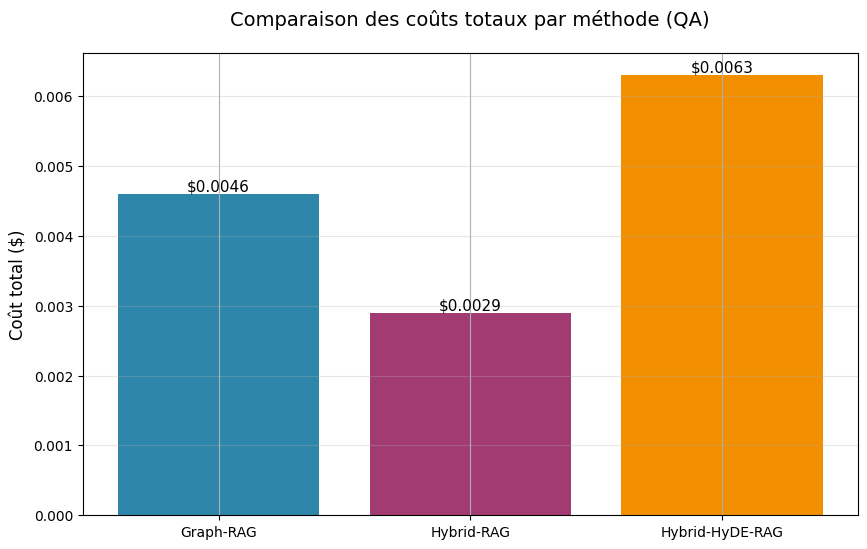

In [53]:
import matplotlib.pyplot as plt
import numpy as np

méthodes = ["Graph-RAG", 'Hybrid-RAG', 'Hybrid-HyDE-RAG']
coûts = [graph_rag_activity["qa_cost_total"], hybrid_rag_activity["cost_total"], hybrid_hyde_rag_activity["cost_total"]]

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(méthodes, coûts, color=['#2E86AB', '#A23B72', '#F18F01'])
ax.set_ylabel('Coût total ($)', fontsize=12)
ax.set_title('Comparaison des coûts totaux par méthode (QA)', fontsize=14, pad=20)
ax.grid(axis='y', alpha=0.3)

# Ajouter les valeurs sur les barres
for bar, coût in zip(bars, coûts):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.0000,
            f'${coût:.4f}', ha='center', va='bottom', fontsize=11)

# plt.tight_layout()
plt.grid(True)
plt.show()

Commentaires:
* le même llm a été utilisé sur toutes les méthodes, sauf le reranker (mistral small 24b)
* Au démarrage le graph rag est le + cher à cause de la création du graphe
* Hors création du graph, la méthode hyde semble la plus chère, mais essentiellement à cause de la longueur de la réponse:
    * hyde: 2000 tokens 
    * graph: 1000 tokens 
    * hybrid simple: 500 tokens
* Classement fait avec gemini 3 pro:

| Réponse | Score | Verdict |
| :--- | :---: | :--- |
| **Graph RAG** | **8.5/10** | Très bonne, excellente structure, mais peut-être moins précise sur le concept clé du texte. |
| **Hybrid simple** | **6.0/10** | Trop synthétique, structure confuse entre thèmes et questions. |
| **Hybrid HyDE** | **9.5/10** | **Gagnante.** Complète, précise, structure logique liant thèmes et questions. |


* En utilisant mistral 3 large (sur le QA) le Graph RAG prend la place de HyDE, et hybrid simple gagne 1 point
* Avec HyDE on peut gagner marginalement avec un + petit LLM (ministral 14b ou gemma 12b), voir un reranker cross encoder, mais avec risque de scores moins pertinents (surtout avec cross encoder)
* L'input tokens sur le graph RAG lors des QA me semble trop élevé:
> Pour une question simple et directe `Qui sont les intervenants dans ce texte ?`, l'input token est de 21k (vs 17k pour la question de référence)
>> Il faudra regarder le détail de la constitution du contexte par la librairie graph
 

==============================

### Evaluation des réponses
#### <u>Le cadre général:</u>
**1. Construire les réponses de référence:**
* Utiliser la question cadre "Quels sont les principaux thèmes de ce texte ?" 
* Charger le transcript du podcast et produire la réponse avec les modèles suivant:
    * Dans le chat openrouter ou par API:
        * openai/gpt-5.2
        * google/gemini-3-pro-preview
        * anthropic/claude-sonnet-4.5
    * Dans NotebookLM (solution spécialisée dans l'analyse des documents)
    
**Important**: relire et comparer les réponses avec votre compréhension du podcast, corriger et valider

**2. Utiliser les réponses de référence pour évaluer les RAGs:**

Pour la question cadre ci dessus, le graphrag est plus apte que le vectoriel

Il existe 2 paramètres techniques principaux qui influencent nettement la qualité des réponses:
* Le modèle d'embedding: 
    * Utilisé lors de la création du graphe dans la structuration des noeuds et leur connexion (par rapprochement cosine sim)
    * Utilisé lors de la lecture du graphe pour répondre à une question, qui mets en relation avec la question avec les noeuds les plus pertinent (cosine sim) pour sélectionner un/des point(s) de démarrage pour l'exploration du graphe
* Le LLM:
    * Utilisé lors de la création du graphe pour la reconnaissance des entités, leur définition a rôles, leurs catégories, les relations entre les entités, la normalisation, déduplication et unification des entités et des catégories ...
    * Utilisé lors de la génération de la réponse, en recevant en entrée les pertinentes parties du graphe comme contexte

#### Un tableau de combinaisons pour l'évaluation

Exemple de grille systématique pour tester les combinaisons de modèles d'embedding et de LLM :

## **Paramètres de Test**

### **Modèles d'Embedding (Colonnes)**
1. **Embedding bon marché**:
* gemma embeddign 300m, ...
2. **Embeddings premium**:
* gemini embedding (via openrouter)
* openai text-embedding-3-large


### **Modèles LLM (Lignes)**
**Pour la création de graphe:**
#### Modèles `performants` et bon marché, éligible pour création de graphe:
* deepseek/deepseek-chat-v3-0324: $0.20/M input tokens | $0.88/M output tokens
* deepseek/deepseek-v3.1-terminus: $0.21/M input tokens | $0.79/M output tokens
* prime-intellect/intellect-3: $0.20/M input tokens | $1.10/M output tokens
* openai/gpt-5-mini: $0,25/M input tokens | $2/M output tokens
* mistralai/mistral-large-2512: $0.50/M input tokens | $1.50/M output tokens
* mistralai/mistral-medium-3.1; $0.40/M input tokens | $2/M output tokens

#### Modèles `frontière`, meilleure qualité attendue, mais prix élevé pour modèles US:
<div class="alert" style="color: red">Attention au prix de l'output variable</div>

* google/gemini-2.5-pro: Starting at $1.25/M input tokens | Starting at $10/M output tokens
* openai/gpt-5.1: $1.25/M input tokens | $10/M output tokens
* deepseek/deepseek-v3.2: $0.28/M input tokens | $0.42/M output tokens
* moonshotai/kimi-k2-thinking: $0.45/M input tokens | $2.35/M output tokens
* z-ai/glm-4.6; $0.39/M input tokens | $1.90/M output tokens

**Pour la génération de réponse:**
En plus des modèles `tiers 2` ci dessus, envisager les modèles suivants, assez performants pour des questions de moindre complexité, et particulièrement peu chers;

* mistralai/mistral-small-3.2-24b-instruct: $0.06/M input tokens | $0.18/M output tokens
* meta-llama/llama-4-maverick: $0.15/M input tokens | $0.60/M output tokens
* z-ai/glm-4.5-air: $0.104/M input tokens | $0.68/M output tokens
* google/gemma-3-27b-it: $0.04/M input tokens | $0.15/M output tokens




## **Tableau de combinaisons (Grid Search)**

| Combinaison | Embedding | LLM (Création) | LLM (Génération) | Coût Relatif | Gestion de la complexité |
|-------------|-----------|----------------|------------------|--------------|------------|
| **C1 - Baseline Économique** | gemma emb | google/gemma-3-27b-it | google/gemma-3-27b-it | Très faible | Simple |
| **C2 - Hybride Léger** | gemma emb | deepseek-v3.1-terminus | mistral small | Faible | moyenne |
| **C3 - Optimal Qualité** | gemma emb | deepseek/deepseek-v3.2 | deepseek/deepseek-v3.2 | Moyen | Elevée |
| **C4 - Maximum Performance** | gemini ou openai large | openai/gpt-5.1 | openai/gpt-5.1 | Très élevé | Elevée|


## **Métriques d'Évaluation par combinaison**

### **Pour chaque combinaison, mesurer :**
1. **Qualité RAG**
   - Précision et couverture de la réponse VS référence
   - RAGAS (Faithfulness, Answer Relevancy)
   - Hallucinations

2. **Performance Technique**
   - Temps création graphe / génération réponses
   - Coût pour création de graphe
   - Coût par requête

3. **Qualité Graphe**
   - Nb de catégories formées
   - Nb de noeuds formés
   - Nombre de connexions



## **Matrice de Décision**

| Critère | Poids | C1 | C2 | C3 | C4 |
|---------|-------|----|----|----|----|
| **Qualité Réponse** | 70% | ⭐⭐ | ⭐⭐⭐ | ⭐⭐⭐⭐ | ⭐⭐⭐⭐⭐ |
| **Coût création graphe** | 10% | ⭐⭐⭐⭐⭐ | ⭐⭐⭐ | ⭐⭐ | ⭐ |
| **Coût génération réponse** | 15% | ⭐⭐⭐⭐⭐ | ⭐⭐⭐⭐⭐ | ⭐⭐⭐ | ⭐ |
| **Temps** | 5% | ⭐⭐⭐⭐⭐ | ⭐⭐⭐⭐⭐ | ⭐⭐⭐ | ⭐⭐ |
| **Score Total** | 100% | **58** | **68** | **72** | **77** |

## **Recommandations**

1. **Démarrer avec C3** (Optimal Qualité)
* Si objectif qualité atteint (proche de C4 - Maximum Performance), tester C3 et mesurer la dégradation
* Si objectif qualité non atteint passer à C4

